In [17]:
# !pip install cellrank
# !pip install scanpy
# !pip install scipy
# !pip install anndata


In [1]:
%%bash

source downloadData.sh

# !mkdir -p ./data
# minimal TF combinations for inducing granulosa-like cells
download_dataset "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE213156&format=file&file=GSE213156%5FTF%5Fgene%5Fexpression%2Ecsv%2Egz" "./data"  "GSE213156_TF_gene_expression.csv.gz"
gunzip_download "./data/GSE213156_TF_gene_expression.csv.gz"

The file ./data/GSE213156_TF_gene_expression.csv.gz already exists. Skipping download.
File ./data/GSE213156_TF_gene_expression.csv already exists. Skipping.


In [18]:
import cellrank as  cr
import scanpy as sc
from scipy import sparse
import pandas as pd
import numpy as np
from anndata import AnnData

 Transcript abundance (TPM) measurements for induced pluripotent stem cells (iPSCs), COV434 ovarian cancer cells, and iPSC-derived granulosa-like cells. 2. Differential gene expression analysis to identify effects of transcription factor overexpression during iPSC differentiation.

In [31]:

# Load h5ad file
df = pd.read_csv('data/GSE213156_TF_gene_expression.csv')

['Gene name', 'Gene stable ID version', 'baseMean', 'log2FoldChange_WT1',
'padj_WT1', 'log2FoldChange_GATA4', 'padj_GATA4',
'log2FoldChange_NR5A1', 'padj_NR5A1', 'log2FoldChange_RUNX1',
'padj_RUNX1', 'log2FoldChange_FOXL2', 'padj_FOXL2',
'log2FoldChange_TCF21', 'padj_TCF21', 'log2FoldChange_COV434',
'padj_COV434', 'log2FoldChange_FOXL2_plus', 'padj_FOXL2_plus',
'log2FoldChange_NOTFS', 'padj_NOTFS']

# the nine TFs are:
    # WT1
    # GATA4
    # NR5A1
    # RUNX1
    # FOXL2
    # TCF21
    # COV434
    # FOXL2_plus
    # NOTFS


# Create anndata object
adata = AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))

print(adata.obs.head())
print(adata.var.head())

# this data is just the abundance of the log2fold change of the TFs. Does not have transcription information? 


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
Empty DataFrame
Columns: []
Index: [Gene name, Gene stable ID version, baseMean, log2FoldChange_WT1, padj_WT1]


/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Here we make both of the anndata objects sparse and change some of the obsm keys. Then we save the new anndata object to h5ad files.

In [ ]:
# # make into sparce matrix

# adata.X = sparse.csr_matrix(adata.X)
# adata2.X = sparse.csr_matrix(adata2.X)

# # first we get the UMAP_orig from X_umap  from the other data object
# adata.obsm["UMAP_orig"] = adata2.obsm["X_umap"]

# # then we save the PCA
# adata.obsm["PCA"] = adata2.obsm["X_pca"]

# # then for harmony
# adata.obsm["PCA_Harmony"] = adata2.obsm["X_pca_harmony"]

# # for diffusion map
# adata.obsm["DiffusionMap"] = adata2.obsm["X_diffmap"]

# !mkdir "./data/tempfile"
# # save adata object
# adata.write_h5ad('./data/tempfile/GSE217460_210322_TFAtlas_differentiated.h5ad')

# # remove old var
# del adata2
# del adata

Continue with processed set. 

In [ ]:
adata = sc.read_h5ad('./data/tempfile/GSE217460_210322_TFAtlas_differentiated.h5ad')

The problem with anndata objects is that some of the variable names have to be preset. For instance `X_umap` is the default name for the UMAP embedding. If you want to use a different name you cannot. 

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


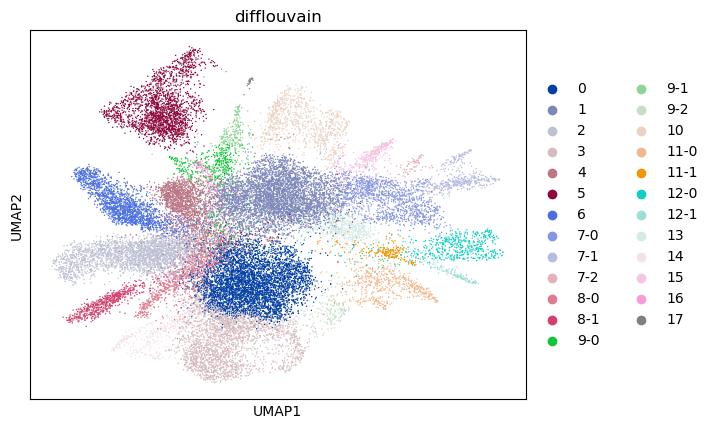

In [ ]:
# umap
adata.obsm["X_umap"] = adata.obsm["UMAP_orig"]
sc.pl.umap(adata, color="difflouvain")

I have to do this because we have 2 umap columns (from 2 different PCAs (harmony and pca)), but the sc.pl.umap function only accepts UMAPs with the name "X_umap". (and or X_pca). It is merely for me to see how the harmony PCA is different form the difflouvian map.

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


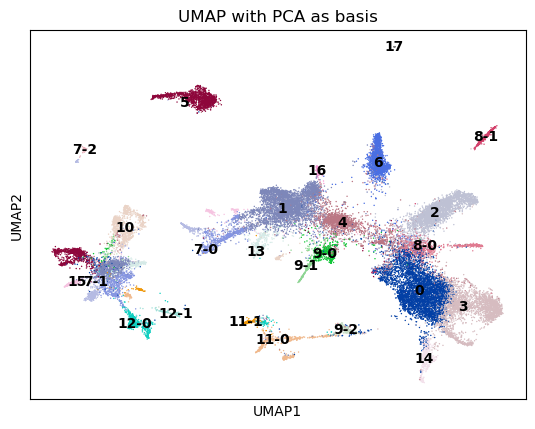

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


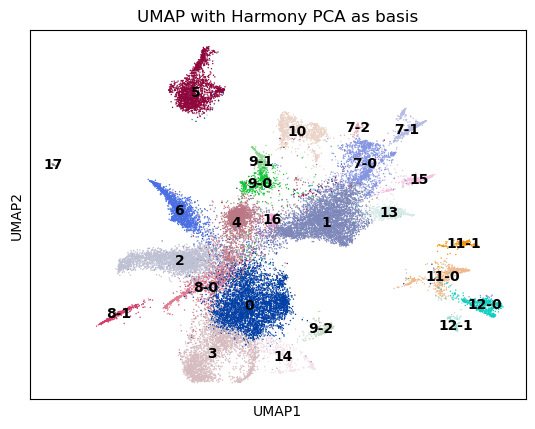

In [ ]:
""""In this block I also store the harmony PCA as X_map. I think this is the better PCA for later use..."""

import umap
import copy as cp

reducer = umap.UMAP()
# Fit the UMAP model using your selected PCA data
embedding = reducer.fit_transform(adata.obsm['PCA'])

# Store the UMAP embedding back into adata.obsm for later reference
adata.obsm["X_map_NOTTHISONE"] = adata.obsm["UMAP_orig"]

# temporary data object
tdata = cp.deepcopy(adata)
tdata.obsm["X_umap"] = embedding

# Plot using Scanpy, specifying the basis custom UMAP
sc.pl.umap(tdata, color='difflouvain', title="UMAP with PCA as basis", legend_loc="on data")
del tdata

reducer = umap.UMAP()
# Fit the UMAP model using your selected PCA data
embedding = reducer.fit_transform(adata.obsm['PCA_Harmony'])

# Store the UMAP embedding back into adata.obsm for later reference
adata.obsm['X_umap'] = embedding

tdata = cp.deepcopy(adata)
tdata.obsm["X_umap"] = embedding

# Plot using Scanpy, specifying the basis as your custom UMAP
sc.pl.umap(adata, color='difflouvain', title="UMAP with Harmony PCA as basis", legend_loc="on data")
del tdata

Here I rename the TFs... And delete the old name column. This is because I want to group them later. 

In [ ]:
tf = "PAX2"

# Ensure the 'TF' column is treated as a string
adata.obs["TF"] = adata.obs["TF"].astype(str)

# Extract just the TF part after the '-' and create a new column (e.g., "New_TF")
adata.obs["New_TF"] = adata.obs["TF"].str.split("-").str[-1]

# sanity check
if tf in adata.obs["New_TF"].unique():
    print("TF is in the list")
else:
    print("TF is not in the list")

# # If you want to replace the original 'TF' column with these new categories:
adata.obs["TF"] = adata.obs["New_TF"]
adata.obs = adata.obs.drop(columns=["New_TF"])


TF is in the list


Now I want to see if the the datapoints from one TF are within the same clusters... Within the R file you assign some sort of entropy score to the TFs.

You use the `cellula:::.getEntropy(x)` function to get the entropy score.

Which is defined as:

```R

#' @noRd
.getEntropy <- function(x) {
    x <- x[x > 0]
    x <- x/sum(x)
    -sum(x * log(x))
}

```
or simply put

$$H(x) = -\sum_{i=1}^{n} p(x_i) \log(p(x_i))$$

with $p(x_i)$ being the probability of the ith event.

First we simply look at the data a bit. Notably here we see about ~1428 groups. Which indicates about 1428 different TFs that we have at least 1 measurement for. (remember sparse matrix).

In [ ]:
# Group the data by 'louvain' and calculate the entropy of 'Has_TF' for each group
# entropy = adata.obs.groupby('TF')['difflouvain'].apply(get_entropy)

groups = adata.obs.groupby('TF')

# Iterate over each group
for name, group in groups:
    print(f"Group name: {name}")
    # print(group) 


# now I do get a bunch of groups with numbers instead of TFs which I don't understand yet why. 
"""
Group name: 1
Group name: 2
Group name: 3
Group name: 5
Group name: 6
Group name: 8
""" 

# print number of groups ~ 1428
print(f"Number of groups: {len(groups)}") 

Group name: 1
Group name: 2
Group name: 3
Group name: 5
Group name: 6
Group name: 8
Group name: ACTL6A
Group name: ADNP2
Group name: AEBP2
Group name: AFF2
Group name: AFF3
Group name: AHRR
Group name: AIRE
Group name: AKNA
Group name: ALX1
Group name: ALX3
Group name: ALX4
Group name: ALYREF
Group name: ANHX
Group name: AP2B1
Group name: APEX1
Group name: AR
Group name: ARGFX
Group name: ARID3A
Group name: ARID3B
Group name: ARID3C
Group name: ARID5A
Group name: ARID5B
Group name: ARNT
Group name: ARNT2
Group name: ARNTL
Group name: ARNTL2
Group name: ARX
Group name: ASCL1
Group name: ASCL2
Group name: ASCL3
Group name: ASCL4
Group name: ASCL5
Group name: ATF1
Group name: ATF2
Group name: ATF3
Group name: ATF4
Group name: ATF5
Group name: ATF6B
Group name: ATF7
Group name: ATMIN
Group name: ATOH1
Group name: ATOH7
Group name: ATOH8
Group name: BACH1
Group name: BARHL1
Group name: BARHL2
Group name: BARX1
Group name: BARX2
Group name: BATF
Group name: BATF2
Group name: BATF3
Group name

Now we look at the entropy get a better measure of what TFs actually contain information

<Axes: title={'center': 'Entropy per TF over clusters'}, xlabel='TF'>

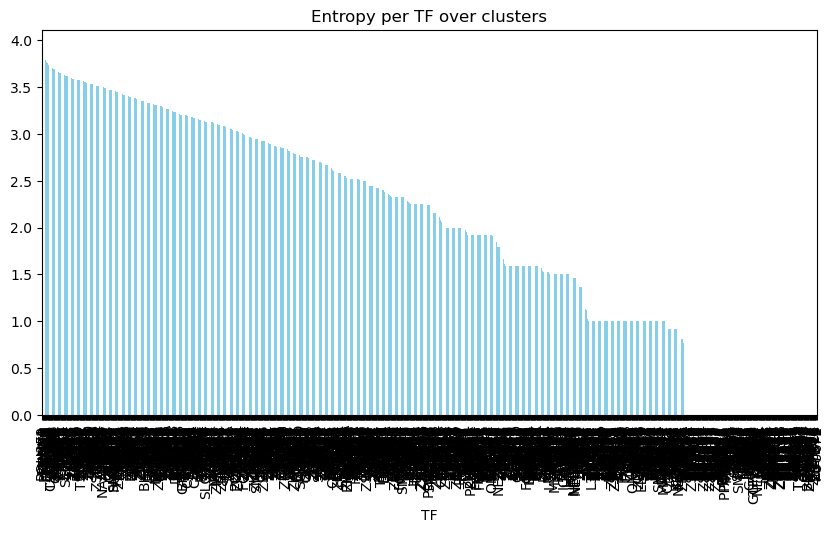

In [ ]:
import pandas as pd
import numpy as np

def calculate_entropy_per_tf(adata):
    # Count the frequency of each TF in each cluster
    frequency_table = adata.obs.groupby(['TF', 'difflouvain']).size().unstack(fill_value=0)
    
    # Convert counts to probabilities
    probabilities = frequency_table.div(frequency_table.sum(axis=1), axis=0)
    
    # Calculate entropy for each TF
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    
    return entropy

entropy_per_tf = calculate_entropy_per_tf(adata)

# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')
# add labels for the clusters

## my results show most of the TFs among their own TF? 
## In this case that would make a lot of sence, because I only have 3 clusters

Here we can clearly see a cutoff. This is because we only look at different cluster not if we look at the releative distance between the points. We have pretty much done a locationless bin. The case where there is many with exactly the same VERY low entropy indicates these have no information as they are all within the same cluster. Which would normally be good, but we need to understand if there is only 2 datapoints, the entropy will be ~0. This is because the probability of the event is 1.

In [ ]:

# looking at the lowest entropy TF

print(entropy_per_tf.tail(10))
# but these are all the same for some reason

# looking at ZBTB7A and ZFP36L1 in the original data

print(adata.obs[adata.obs['TF'] == "ZBTB7A"])
print(adata.obs[adata.obs['TF'] == "ZFP36L1"])

# both are in difflouvain 7-0

# look for all the TF that  are in diffloouvain 7-0 and print their entropy

print(entropy_per_tf[adata.obs[adata.obs['difflouvain'] == "7-0"]['TF'].unique()])

# where we see there is quite some variation in the entropy of the TFs in this cluster
# I dont know why there is so many with this specific entropy... 

# print all the TFs that have the same entropy as ZBTB7A
print(entropy_per_tf[entropy_per_tf == entropy_per_tf["ZBTB7A"]])

# which is a bout 240 TFs
# maybe this is because I don't remove the TFs that are not expressed in the data? 

print(adata.obs[adata.obs['difflouvain'] == "7-0"]['TF'].unique())

print(entropy_per_tf[entropy_per_tf == 1.0])



TF
ZBTB7A    -1.442695e-09
ZFY       -1.442695e-09
ZFP92     -1.442695e-09
ZFP91     -1.442695e-09
ZFP57     -1.442695e-09
ZFP36L1   -1.442695e-09
ZFP14     -1.442695e-09
ZBTB7C    -1.442695e-09
ZBTB7B    -1.442695e-09
POU6F2    -1.442695e-09
dtype: float64
                                   TF batch louvain  n_counts  n_genes  \
R1.48,R2.55,R3.15,P1.30-0-0    ZBTB7A     0       6    2578.0     1807   
R1.39,R2.93,R3.59,P1.55-0-3-0  ZBTB7A     0       6    5036.0     2995   

                               percent_mito batchTF     score  \
R1.48,R2.55,R3.15,P1.30-0-0        0.024438    2585  0.551119   
R1.39,R2.93,R3.59,P1.55-0-3-0      0.029388    2585  0.395131   

                                           temp  dpt_pseudotime  \
R1.48,R2.55,R3.15,P1.30-0-0    TFORF1337-ZBTB7A        0.228518   
R1.39,R2.93,R3.59,P1.55-0-3-0  TFORF1337-ZBTB7A        0.289792   

                               m3_pseudotime difflouvain  
R1.48,R2.55,R3.15,P1.30-0-0         0.594754         7-0  
R1.

AnnData object with n_obs × n_vars = 2 × 37528
    obs: 'TF', 'batch', 'louvain', 'n_counts', 'n_genes', 'percent_mito', 'batchTF', 'score', 'temp', 'dpt_pseudotime', 'm3_pseudotime', 'difflouvain'
    uns: 'difflouvain_colors'
    obsm: 'DiffusionMap', 'PCA', 'PCA_Harmony', 'UMAP_orig', 'X_umap', 'X_map_NOTTHISONE'
R1.48,R2.55,R3.15,P1.30-0-0      7-0
R1.39,R2.93,R3.59,P1.55-0-3-0    7-0
Name: difflouvain, dtype: category
Categories (1, object): ['7-0']


/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


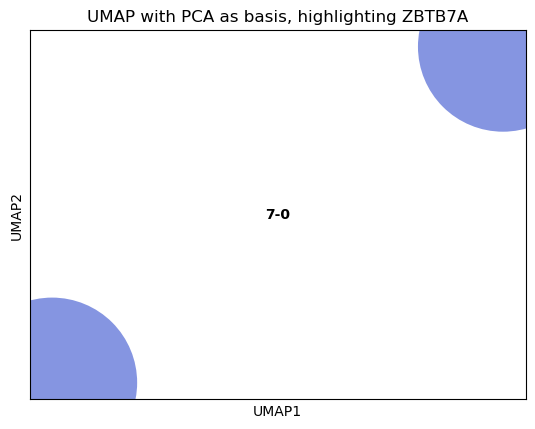

In [ ]:
# Create a new AnnData object containing only the cells where TF == 'ZBTB7A'

# Filter the original adata to include only cells where TF == 'ZBTB7A'
adata_zbtb7a = adata[adata.obs['TF'] == 'ZBTB7A', :].copy()
print(adata_zbtb7a)
print(adata_zbtb7a.obs["difflouvain"])
### OOOOH JOH ZE ZITTEN BEIDEN IN DEZELFDE CLUSTER

# Now plot the UMAP for this subset
sc.pl.umap(adata_zbtb7a, color='difflouvain', title="UMAP with PCA as basis, highlighting ZBTB7A", legend_loc="on data")


Number of groups before filtering: 200
Number of groups after filtering TF datapoints with number of counts is 5: 200
Number of groups after filtering TFs with entropy over 2.5: 200


<Axes: title={'center': 'TFs as a function of value_counts()'}, xlabel='TF'>

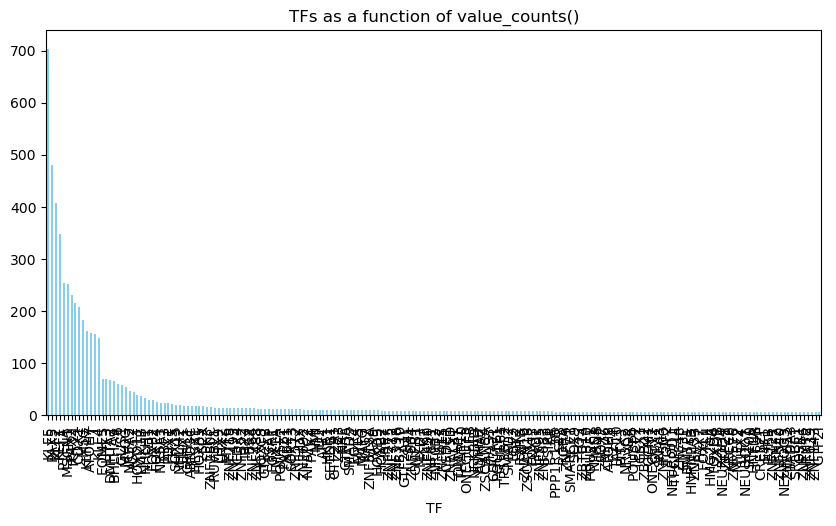

In [ ]:
# now I want to print the entropy distribution of the TFs after removing the TFs that are not expressed in the data

COUNT_VAR = 5
ENTROPY_VAR = 2.5 # I still think this is a crude approach 

# number of groups
print(f"Number of groups before filtering: {len(adata.obs['TF'].value_counts())}")
adata = adata[adata.obs['TF'].isin(adata.obs['TF'].value_counts()[adata.obs['TF'].value_counts() > COUNT_VAR].index), :]
print(f"Number of groups after filtering TF datapoints with number of counts is {COUNT_VAR}: {len(adata.obs['TF'].value_counts())}")


# remove all the TFs that have entropy over 3
adata = adata[adata.obs['TF'].isin(entropy_per_tf[entropy_per_tf < ENTROPY_VAR].index), :]
print(f"Number of groups after filtering TFs with entropy over {ENTROPY_VAR}: {len(adata.obs['TF'].value_counts())}")

# print the entropy distribution of the TFs.
entropy_per_tf = calculate_entropy_per_tf(adata)
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

# plot TFs as a function of value_counts()
adata.obs['TF'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue', title='TFs as a function of value_counts()')
